In [6]:
!pip install scikit-learn -q

In [7]:
#from config import COMMON_CONFIG
class COMMON_CONFIG:
    CASH = 1_000_000
    COMMISSION = .002
    SEED = 777
    SYMBOL = 'ETH/USDT'
    TIMEFRAME = '1h'
    START_DATE = '2024-01-01T00:00:00Z'
    VAL_DATA_OFFSET = 2,
    TEST_DATA_OFFSET = 1,
    ML_TARGET_NEXT_PERIOD_OFFSET = -1
    TA_MAX_STAT = 'Profit Factor'
    TA_KOEF = ML_TARGET_NEXT_PERIOD_OFFSET * -1
    BT_BEST_PARAMS_TA_TEST_DATA_FILE = 'bt_best_params_test_data.csv'
    TS_FRESH_MIN_WINDOW_SIZE = 5
    TS_FRESH_MAX_WINDOW_SIZE = 60

In [8]:
!pip install matplotlib -q
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

!pip install pandas -q
import pandas as pd
# Хак чтобы работало на Anaconda под MacOs 10.15.7 Catalina
pd.DataFrame.iteritems = pd.DataFrame.items

In [285]:
#!pip install git+https://github.com/kernc/backtesting.py.git -q
!pip install backtesting -q

from backtesting import Strategy
from backtesting_utils import run_backtest
from backtesting_utils import convert_data_to_bt_format

In [10]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import random
import numpy as np

def seed_everything(seed: int = COMMON_CONFIG.SEED) -> None:
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    print(f"Using {seed} seed")

# Зафиксируем SEED
seed_everything(COMMON_CONFIG.SEED)

Using 777 seed


In [11]:
!pip install ccxt -q

#from config import COMMON_CONFIG
from api import get_data_from_api
from file_utils import save_data_to_file

# df = get_data_from_api(COMMON_CONFIG.SYMBOL, COMMON_CONFIG.TIMEFRAME, COMMON_CONFIG.START_DATE)
# save_data_to_file(df, COMMON_CONFIG.SYMBOL, COMMON_CONFIG.TIMEFRAME)
# df

In [252]:
from file_utils import read_data_from_file
#from data_utils import train_test_split

df = read_data_from_file(COMMON_CONFIG.SYMBOL, COMMON_CONFIG.TIMEFRAME)
df

,open,high,low,close,volume
date,,,,,
2024-01-01 00:00:00,2281.87,2297.18,2281.27,2295.51,10771.9183
2024-01-01 01:00:00,2295.52,2306.60,2292.90,2303.72,8413.4260
2024-01-01 02:00:00,2303.72,2304.72,2291.20,2293.02,5808.2533
2024-01-01 03:00:00,2293.03,2294.50,2271.00,2273.81,10745.7360
2024-01-01 04:00:00,2273.80,2279.86,2265.24,2279.55,9681.5762
...,...,...,...,...,...
2025-01-26 10:00:00,3298.50,3306.76,3295.81,3305.98,7225.4917
2025-01-26 11:00:00,3305.99,3316.55,3302.73,3312.30,6790.3126
2025-01-26 12:00:00,3312.30,3312.30,3300.14,3307.77,7222.1993


In [13]:
!pip install tsfresh -q

from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh.utilities.dataframe_functions import impute

In [253]:
df_for_tsfresh = df.copy()
df_for_tsfresh

,open,high,low,close,volume
date,,,,,
2024-01-01 00:00:00,2281.87,2297.18,2281.27,2295.51,10771.9183
2024-01-01 01:00:00,2295.52,2306.60,2292.90,2303.72,8413.4260
2024-01-01 02:00:00,2303.72,2304.72,2291.20,2293.02,5808.2533
2024-01-01 03:00:00,2293.03,2294.50,2271.00,2273.81,10745.7360
2024-01-01 04:00:00,2273.80,2279.86,2265.24,2279.55,9681.5762
...,...,...,...,...,...
2025-01-26 10:00:00,3298.50,3306.76,3295.81,3305.98,7225.4917
2025-01-26 11:00:00,3305.99,3316.55,3302.73,3312.30,6790.3126
2025-01-26 12:00:00,3312.30,3312.30,3300.14,3307.77,7222.1993


In [254]:
df_melted = pd.DataFrame()
df_melted["timestamp"] = df_for_tsfresh.index
df_melted["close"] = df_for_tsfresh['close'].values
df_melted['symbol'] = COMMON_CONFIG.SYMBOL.replace('/', '')
df_melted.tail(3)

,timestamp,close,symbol
9396,2025-01-26 12:00:00,3307.77,ETHUSDT
9397,2025-01-26 13:00:00,3307.84,ETHUSDT
9398,2025-01-26 14:00:00,3300.78,ETHUSDT


In [49]:
df_melted

,timestamp,close,symbol
0,2024-01-01 00:00:00,2295.51,ETHUSDT
1,2024-01-01 01:00:00,2303.72,ETHUSDT
2,2024-01-01 02:00:00,2293.02,ETHUSDT
3,2024-01-01 03:00:00,2273.81,ETHUSDT
4,2024-01-01 04:00:00,2279.55,ETHUSDT
...,...,...,...
9394,2025-01-26 10:00:00,3305.98,ETHUSDT
9395,2025-01-26 11:00:00,3312.30,ETHUSDT
9396,2025-01-26 12:00:00,3307.77,ETHUSDT
9397,2025-01-26 13:00:00,3307.84,ETHUSDT


In [255]:
df_rolled = roll_time_series(df_melted, column_id="symbol", column_sort="timestamp",
                             min_timeshift=COMMON_CONFIG.TS_FRESH_MIN_WINDOW_SIZE,
                             max_timeshift=COMMON_CONFIG.TS_FRESH_MAX_WINDOW_SIZE)
df_rolled

Rolling: 100%|██████████| 40/40 [00:06<00:00,  6.41it/s]


,timestamp,close,symbol,id
0,2024-01-01 00:00:00,2295.51,ETHUSDT,"(ETHUSDT, 2024-01-01 05:00:00)"
1,2024-01-01 01:00:00,2303.72,ETHUSDT,"(ETHUSDT, 2024-01-01 05:00:00)"
2,2024-01-01 02:00:00,2293.02,ETHUSDT,"(ETHUSDT, 2024-01-01 05:00:00)"
3,2024-01-01 03:00:00,2273.81,ETHUSDT,"(ETHUSDT, 2024-01-01 05:00:00)"
4,2024-01-01 04:00:00,2279.55,ETHUSDT,"(ETHUSDT, 2024-01-01 05:00:00)"
...,...,...,...,...
571489,2025-01-26 10:00:00,3305.98,ETHUSDT,"(ETHUSDT, 2025-01-26 14:00:00)"
571490,2025-01-26 11:00:00,3312.30,ETHUSDT,"(ETHUSDT, 2025-01-26 14:00:00)"
571491,2025-01-26 12:00:00,3307.77,ETHUSDT,"(ETHUSDT, 2025-01-26 14:00:00)"
571492,2025-01-26 13:00:00,3307.84,ETHUSDT,"(ETHUSDT, 2025-01-26 14:00:00)"


In [109]:
df_rolled

,timestamp,close,symbol,id
0,2024-01-01 00:00:00,2295.51,ETHUSDT,"(ETHUSDT, 2024-01-01 05:00:00)"
1,2024-01-01 01:00:00,2303.72,ETHUSDT,"(ETHUSDT, 2024-01-01 05:00:00)"
2,2024-01-01 02:00:00,2293.02,ETHUSDT,"(ETHUSDT, 2024-01-01 05:00:00)"
3,2024-01-01 03:00:00,2273.81,ETHUSDT,"(ETHUSDT, 2024-01-01 05:00:00)"
4,2024-01-01 04:00:00,2279.55,ETHUSDT,"(ETHUSDT, 2024-01-01 05:00:00)"
...,...,...,...,...
571489,2025-01-26 10:00:00,3305.98,ETHUSDT,"(ETHUSDT, 2025-01-26 14:00:00)"
571490,2025-01-26 11:00:00,3312.30,ETHUSDT,"(ETHUSDT, 2025-01-26 14:00:00)"
571491,2025-01-26 12:00:00,3307.77,ETHUSDT,"(ETHUSDT, 2025-01-26 14:00:00)"
571492,2025-01-26 13:00:00,3307.84,ETHUSDT,"(ETHUSDT, 2025-01-26 14:00:00)"


In [256]:
X = extract_features(df_rolled.drop("symbol", axis=1), 
                     column_id="id", column_sort="timestamp", column_value="close", 
                     impute_function=impute, show_warnings=False)
X

Feature Extraction: 100%|██████████| 40/40 [01:19<00:00,  1.99s/it]


close__variance_larger_than_standard_deviation  \
ETHUSDT 2024-01-01 05:00:00                                             1.0   
        2024-01-01 06:00:00                                             1.0   
        2024-01-01 07:00:00                                             1.0   
        2024-01-01 08:00:00                                             1.0   
        2024-01-01 09:00:00                                             1.0   
...                                                                     ...   
        2025-01-26 10:00:00                                             1.0   
        2025-01-26 11:00:00                                             1.0   
        2025-01-26 12:00:00                                             1.0   
        2025-01-26 13:00:00                                             1.0   
        2025-01-26 14:00:00                                             1.0   

                             close__has_duplicate_max  \
ETHUSDT 2024-01-01 05:00:00                       0.0   
        2024-01-01 06:00:00                       0.0   
        2024-01-01 07:00:00                       0.0   
        2024-01-01 08:00:00                       0.0   
        2024-01-01 09:00:00                       0.0   
...                                               ...   
        2025-01-26 10:00:00                       0.0   
        2025-01-26 11:00:00                       0.0   
        2025-01-26 12:00:00                       0.0   
        2025-01-26 13:00:00                       0.0   
        2025-01-26 14:00:00                       0.0   

                             close__has_duplicate_min  close__has_duplicate  \
ETHUSDT 2024-01-01 05:00:00                       0.0                   0.0   
        2024-01-01 06:00:00                       0.0                   0.0   
        2024-01-01 07:00:00                       0.0                   0.0   
        2024-01-01 08:00:00                       0.0                   0.0   
        2024-01-01 09:00:00                       0.0                   0.0   
...                                               ...                   ...   
        2025-01-26 10:00:00                       0.0                   0.0   
        2025-01-26 11:00:00                       0.0                   0.0   
        2025-01-26 12:00:00                       0.0                   0.0   
        2025-01-26 13:00:00                       0.0                   0.0   
        2025-01-26 14:00:00                       0.0                   0.0   

                             close__sum_values  close__abs_energy  \
ETHUSDT 2024-01-01 05:00:00           13721.50       3.138067e+07   
        2024-01-01 06:00:00           16003.40       3.658774e+07   
        2024-01-01 07:00:00           18288.07       4.180745e+07   
        2024-01-01 08:00:00           20575.08       4.703787e+07   
        2024-01-01 09:00:00           22874.88       5.232695e+07   
...                                        ...                ...   
        2025-01-26 10:00:00          203498.43       6.789665e+08   
        2025-01-26 11:00:00          203488.37       6.788998e+08   
        2025-01-26 12:00:00          203457.93       6.786975e+08   
        2025-01-26 13:00:00          203480.35       6.788453e+08   
        2025-01-26 14:00:00          203482.64       6.788604e+08   

                             close__mean_abs_change  close__mean_change  \
ETHUSDT 2024-01-01 05:00:00                9.504000           -3.924000   
        2024-01-01 06:00:00                8.921667           -2.268333   
        2024-01-01 07:00:00                8.042857           -1.548571   
        2024-01-01 08:00:00                7.330000           -1.062500   
        2024-01-01 09:00:00                7.936667            0.476667   
...                                             ...                 ...   
        2025-01-26 10:00:00               12.495667           -0.273000   
        2025-01-2

In [257]:
X = X.set_index(X.index.map(lambda x: x[1]), drop=True)
X.index.name = "last_timestamp"
X

,close__variance_larger_than_standard_deviation,close__has_duplicate_max,close__has_duplicate_min,close__has_duplicate,close__sum_values,close__abs_energy,close__mean_abs_change,close__mean_change,close__mean_second_derivative_central,close__median,...,close__fourier_entropy__bins_5,close__fourier_entropy__bins_10,close__fourier_entropy__bins_100,close__permutation_entropy__dimension_3__tau_1,close__permutation_entropy__dimension_4__tau_1,close__permutation_entropy__dimension_5__tau_1,close__permutation_entropy__dimension_6__tau_1,close__permutation_entropy__dimension_7__tau_1,close__query_similarity_count__query_None__threshold_0.0,close__mean_n_absolute_max__number_of_maxima_7
last_timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-01 05:00:00,1.0,0.0,0.0,0.0,13721.50,3.138067e+07,9.504000,-3.924000,-1.483750,2286.285,...,1.039721,1.039721,1.386294,1.386294,1.098612,0.693147,-0.000000,3.982128,0.0,3215.345714
2024-01-01 06:00:00,1.0,0.0,0.0,0.0,16003.40,3.658774e+07,8.921667,-2.268333,-0.220000,2281.900,...,0.562335,1.039721,1.386294,1.609438,1.386294,1.098612,0.693147,-0.000000,0.0,3215.345714
2024-01-01 07:00:00,1.0,0.0,0.0,0.0,18288.07,4.180745e+07,8.042857,-1.548571,-0.453333,2283.285,...,0.950271,0.950271,1.609438,1.791759,1.609438,1.386294,1.098612,0.693147,0.0,2287.751429
2024-01-01 08:00:00,1.0,0.0,0.0,0.0,20575.08,4.703787e+07,7.330000,-1.062500,-0.419286,2284.670,...,0.950271,1.332179,1.609438,1.747868,1.791759,1.609438,1.386294,1.098612,0.0,2289.340000
2024-01-01 09:00:00,1.0,0.0,0.0,0.0,22874.88,5.232695e+07,7.936667,0.476667,0.286250,2285.840,...,0.867563,1.329661,1.791759,1.667462,1.747868,1.791759,1.609438,1.386294,0.0,2292.232857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-26 10:00:00,1.0,0.0,0.0,0.0,203498.43,6.789665e+08,12.495667,-0.273000,-0.070932,3332.080,...,0.239217,0.379535,1.277661,1.702229,2.675075,3.387914,3.817966,3.956922,0.0,3404.132857
2025-01-26 11:00:00,1.0,0.0,0.0,0.0,203488.37,6.788998e+08,12.336833,-0.431833,0.500932,3332.080,...,0.239217,0.379535,1.232942,1.692258,2.642152,3.354413,3.793211,3.956922,0.0,3404.132857
2025-01-26 12:00:00,1.0,0.0,0.0,0.0,203457.93,6.786975e+08,11.532500,0.372500,-0.149153,3331.180,...,0.239217,0.473981,1.232942,1.694687,2.638680,3.330092,3.768455,3.956922,0.0,3404.132857


In [258]:
y = df_melted.set_index("timestamp").sort_index().close.shift(-1)
y.tail(3)

timestamp
2025-01-26 12:00:00    3307.84
2025-01-26 13:00:00    3300.78
2025-01-26 14:00:00        NaN
Name: close, dtype: float64

In [259]:
y = y[y.index.isin(X.index)]
X = X[X.index.isin(y.index)]

In [165]:
X

,close__variance_larger_than_standard_deviation,close__has_duplicate_max,close__has_duplicate_min,close__has_duplicate,close__sum_values,close__abs_energy,close__mean_abs_change,close__mean_change,close__mean_second_derivative_central,close__median,...,close__fourier_entropy__bins_5,close__fourier_entropy__bins_10,close__fourier_entropy__bins_100,close__permutation_entropy__dimension_3__tau_1,close__permutation_entropy__dimension_4__tau_1,close__permutation_entropy__dimension_5__tau_1,close__permutation_entropy__dimension_6__tau_1,close__permutation_entropy__dimension_7__tau_1,close__query_similarity_count__query_None__threshold_0.0,close__mean_n_absolute_max__number_of_maxima_7
last_timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-01 05:00:00,1.0,0.0,0.0,0.0,13721.50,3.138067e+07,9.504000,-3.924000,-1.483750,2286.285,...,1.039721,1.039721,1.386294,1.386294,1.098612,0.693147,-0.000000,3.982128,0.0,3215.345714
2024-01-01 06:00:00,1.0,0.0,0.0,0.0,16003.40,3.658774e+07,8.921667,-2.268333,-0.220000,2281.900,...,0.562335,1.039721,1.386294,1.609438,1.386294,1.098612,0.693147,-0.000000,0.0,3215.345714
2024-01-01 07:00:00,1.0,0.0,0.0,0.0,18288.07,4.180745e+07,8.042857,-1.548571,-0.453333,2283.285,...,0.950271,0.950271,1.609438,1.791759,1.609438,1.386294,1.098612,0.693147,0.0,2287.751429
2024-01-01 08:00:00,1.0,0.0,0.0,0.0,20575.08,4.703787e+07,7.330000,-1.062500,-0.419286,2284.670,...,0.950271,1.332179,1.609438,1.747868,1.791759,1.609438,1.386294,1.098612,0.0,2289.340000
2024-01-01 09:00:00,1.0,0.0,0.0,0.0,22874.88,5.232695e+07,7.936667,0.476667,0.286250,2285.840,...,0.867563,1.329661,1.791759,1.667462,1.747868,1.791759,1.609438,1.386294,0.0,2292.232857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-26 10:00:00,1.0,0.0,0.0,0.0,203498.43,6.789665e+08,12.495667,-0.273000,-0.070932,3332.080,...,0.239217,0.379535,1.277661,1.702229,2.675075,3.387914,3.817966,3.956922,0.0,3404.132857
2025-01-26 11:00:00,1.0,0.0,0.0,0.0,203488.37,6.788998e+08,12.336833,-0.431833,0.500932,3332.080,...,0.239217,0.379535,1.232942,1.692258,2.642152,3.354413,3.793211,3.956922,0.0,3404.132857
2025-01-26 12:00:00,1.0,0.0,0.0,0.0,203457.93,6.786975e+08,11.532500,0.372500,-0.149153,3331.180,...,0.239217,0.473981,1.232942,1.694687,2.638680,3.330092,3.768455,3.956922,0.0,3404.132857


In [132]:
y

timestamp
2024-01-01 05:00:00    2275.89
2024-01-01 06:00:00    2281.90
2024-01-01 07:00:00    2284.67
2024-01-01 08:00:00    2287.01
2024-01-01 09:00:00    2299.80
                        ...   
2025-01-26 10:00:00    3305.98
2025-01-26 11:00:00    3312.30
2025-01-26 12:00:00    3307.77
2025-01-26 13:00:00    3307.84
2025-01-26 14:00:00    3300.78
Name: close, Length: 9394, dtype: float64

In [23]:
def train_test_split(_data):
    # Определяем дату начала тестовой выборки
    _test_start_date = _data.index.max() - pd.DateOffset(months=int(COMMON_CONFIG.TEST_DATA_OFFSET[0]))

    # Разделение данных на тренировочную и тестовую выборки по времени
    _train_data = _data[_data.index < _test_start_date]
    _test_data = _data[_data.index >= _test_start_date]

    print(f"Train size: {len(_train_data)}, Test size: {len(_test_data)}")
    return _train_data, _test_data

In [260]:
X_train, X_test = train_test_split(X)

Train size: 8649, Test size: 745


In [153]:
X_train

,close__variance_larger_than_standard_deviation,close__has_duplicate_max,close__has_duplicate_min,close__has_duplicate,close__sum_values,close__abs_energy,close__mean_abs_change,close__mean_change,close__mean_second_derivative_central,close__median,...,close__fourier_entropy__bins_5,close__fourier_entropy__bins_10,close__fourier_entropy__bins_100,close__permutation_entropy__dimension_3__tau_1,close__permutation_entropy__dimension_4__tau_1,close__permutation_entropy__dimension_5__tau_1,close__permutation_entropy__dimension_6__tau_1,close__permutation_entropy__dimension_7__tau_1,close__query_similarity_count__query_None__threshold_0.0,close__mean_n_absolute_max__number_of_maxima_7
last_timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-01 05:00:00,1.0,0.0,0.0,0.0,13721.50,3.138067e+07,9.504000,-3.924000,-1.483750,2286.285,...,1.039721,1.039721,1.386294,1.386294,1.098612,0.693147,-0.000000,3.982128,0.0,3215.345714
2024-01-01 06:00:00,1.0,0.0,0.0,0.0,16003.40,3.658774e+07,8.921667,-2.268333,-0.220000,2281.900,...,0.562335,1.039721,1.386294,1.609438,1.386294,1.098612,0.693147,-0.000000,0.0,3215.345714
2024-01-01 07:00:00,1.0,0.0,0.0,0.0,18288.07,4.180745e+07,8.042857,-1.548571,-0.453333,2283.285,...,0.950271,0.950271,1.609438,1.791759,1.609438,1.386294,1.098612,0.693147,0.0,2287.751429
2024-01-01 08:00:00,1.0,0.0,0.0,0.0,20575.08,4.703787e+07,7.330000,-1.062500,-0.419286,2284.670,...,0.950271,1.332179,1.609438,1.747868,1.791759,1.609438,1.386294,1.098612,0.0,2289.340000
2024-01-01 09:00:00,1.0,0.0,0.0,0.0,22874.88,5.232695e+07,7.936667,0.476667,0.286250,2285.840,...,0.867563,1.329661,1.791759,1.667462,1.747868,1.791759,1.609438,1.386294,0.0,2292.232857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-26 09:00:00,1.0,0.0,0.0,0.0,210726.63,7.280513e+08,14.755833,-0.843167,-0.260424,3470.680,...,0.283936,0.424254,1.572172,1.747248,2.818869,3.617197,3.951086,4.007333,0.0,3498.342857
2024-12-26 10:00:00,1.0,0.0,0.0,0.0,210673.04,7.276873e+08,14.194667,-1.504333,0.289407,3470.680,...,0.283936,0.424254,1.509277,1.745123,2.829084,3.617197,3.951086,4.007333,0.0,3498.342857
2024-12-26 11:00:00,1.0,0.0,0.0,0.0,210586.64,7.270969e+08,13.639833,-0.820833,0.062373,3470.680,...,0.283936,0.283936,1.365070,1.750597,2.831971,3.650698,3.951086,4.007333,0.0,3498.342857


In [154]:
X_test

,close__variance_larger_than_standard_deviation,close__has_duplicate_max,close__has_duplicate_min,close__has_duplicate,close__sum_values,close__abs_energy,close__mean_abs_change,close__mean_change,close__mean_second_derivative_central,close__median,...,close__fourier_entropy__bins_5,close__fourier_entropy__bins_10,close__fourier_entropy__bins_100,close__permutation_entropy__dimension_3__tau_1,close__permutation_entropy__dimension_4__tau_1,close__permutation_entropy__dimension_5__tau_1,close__permutation_entropy__dimension_6__tau_1,close__permutation_entropy__dimension_7__tau_1,close__query_similarity_count__query_None__threshold_0.0,close__mean_n_absolute_max__number_of_maxima_7
last_timestamp,,,,,,,,,,,,,,,,,,,,,
2024-12-26 14:00:00,1.0,0.0,0.0,0.0,210413.95,7.259289e+08,13.365000,-0.546000,-0.325169,3470.68,...,0.239217,0.283936,1.147973,1.756306,2.874225,3.708519,4.000596,4.007333,0.0,3498.342857
2024-12-26 15:00:00,1.0,0.0,0.0,0.0,210385.32,7.257366e+08,13.030833,-0.880167,-0.103814,3470.68,...,0.283936,0.283936,1.147973,1.765988,2.874225,3.708519,3.975841,4.007333,0.0,3498.342857
2024-12-26 16:00:00,1.0,0.0,0.0,0.0,210345.35,7.254667e+08,12.971833,-0.939167,0.018475,3470.68,...,0.283936,0.283936,1.061467,1.765988,2.913006,3.708519,3.975841,4.007333,0.0,3498.342857
2024-12-26 17:00:00,1.0,0.0,0.0,0.0,210259.73,7.248895e+08,13.282000,-1.604667,0.010932,3470.68,...,0.283936,0.283936,0.928839,1.765988,2.898126,3.708519,3.975841,4.007333,0.0,3498.342857
2024-12-26 18:00:00,1.0,0.0,0.0,0.0,210173.13,7.243040e+08,12.934000,-0.934000,0.015932,3470.68,...,0.283936,0.283936,0.928839,1.765988,2.898126,3.684198,3.975841,4.007333,0.0,3498.342857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-26 10:00:00,1.0,0.0,0.0,0.0,203498.43,6.789665e+08,12.495667,-0.273000,-0.070932,3332.08,...,0.239217,0.379535,1.277661,1.702229,2.675075,3.387914,3.817966,3.956922,0.0,3404.132857
2025-01-26 11:00:00,1.0,0.0,0.0,0.0,203488.37,6.788998e+08,12.336833,-0.431833,0.500932,3332.08,...,0.239217,0.379535,1.232942,1.692258,2.642152,3.354413,3.793211,3.956922,0.0,3404.132857
2025-01-26 12:00:00,1.0,0.0,0.0,0.0,203457.93,6.786975e+08,11.532500,0.372500,-0.149153,3331.18,...,0.239217,0.473981,1.232942,1.694687,2.638680,3.330092,3.768455,3.956922,0.0,3404.132857


In [261]:
y_train, y_test = train_test_split(y)

Train size: 8649, Test size: 745


In [156]:
y_train

timestamp
2024-01-01 05:00:00    2275.89
2024-01-01 06:00:00    2281.90
2024-01-01 07:00:00    2284.67
2024-01-01 08:00:00    2287.01
2024-01-01 09:00:00    2299.80
                        ...   
2024-12-26 09:00:00    3372.42
2024-12-26 10:00:00    3369.42
2024-12-26 11:00:00    3373.28
2024-12-26 12:00:00    3358.02
2024-12-26 13:00:00    3354.19
Name: close, Length: 8649, dtype: float64

In [245]:
y_test

timestamp
2024-12-26 13:00:00    3340.00
2024-12-26 14:00:00    3344.13
2024-12-26 15:00:00    3356.97
2024-12-26 16:00:00    3327.70
2024-12-26 17:00:00    3337.38
                        ...   
2025-01-26 09:00:00    3305.98
2025-01-26 10:00:00    3312.30
2025-01-26 11:00:00    3307.77
2025-01-26 12:00:00    3307.84
2025-01-26 13:00:00        NaN
Name: close, Length: 745, dtype: float64

In [262]:
X_train_selected = select_features(X_train, y_train)
X_train_selected

,close__sum_values,"close__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)","close__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)","close__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)","close__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)","close__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)","close__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)","close__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)","close__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)","close__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)",...,"close__fft_coefficient__attr_""angle""__coeff_4",close__number_cwt_peaks__n_1,close__symmetry_looking__r_0.15000000000000002,"close__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20)",close__ar_coefficient__coeff_5__k_10,"close__agg_autocorrelation__f_agg_""var""__maxlag_40",close__autocorrelation__lag_7,"close__fft_coefficient__attr_""angle""__coeff_20",close__approximate_entropy__m_2__r_0.7,close__partial_autocorrelation__lag_7
last_timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-01 05:00:00,13721.50,2419.006327,1754.275697,114.544167,3538.835874,4753.124259,9500.588496,3180.255502,5094.564477,9999.588187,...,19.931812,1.0,1.0,4.446319,0.018087,0.331864,0.427735,5.195358,0.054115,-0.031273
2024-01-01 06:00:00,16003.40,2990.573555,2186.952116,1757.387767,2872.873490,2371.617917,1744.012754,3180.255502,5094.564477,9999.588187,...,19.931812,1.0,1.0,4.446319,0.018087,0.241768,0.427735,5.195358,0.089726,-0.031273
2024-01-01 07:00:00,18288.07,4114.830615,3052.391375,2477.937167,4220.395185,3541.135445,2616.092493,3450.077791,2933.975740,2175.261936,...,0.000000,1.0,1.0,4.446319,0.018087,0.163707,-0.133068,5.195358,0.042651,-0.031273
2024-01-01 08:00:00,20575.08,4615.856334,3472.552712,2113.821169,4627.124026,4066.797716,3040.823960,3941.526663,3475.903845,2602.928799,...,81.478315,1.0,1.0,1195.960245,0.018087,0.142235,0.012041,5.195358,0.026447,-0.031273
2024-01-01 09:00:00,22874.88,5540.906443,4300.764246,1030.948533,5276.855887,5087.095294,3888.662406,4924.935947,4566.681495,3462.349180,...,147.314349,1.0,1.0,2041.854560,0.018087,0.443405,0.134704,5.195358,0.031530,-0.031273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-26 09:00:00,210726.63,4579.596009,9803.570530,86.321225,3824.203508,5074.434492,10386.103039,3414.622425,5444.723973,10938.555392,...,-113.077167,7.0,1.0,21.085889,-0.078060,0.198097,0.359331,-42.768106,0.294904,0.006856
2024-12-26 10:00:00,210673.04,4572.557790,9808.574818,121.096062,3808.150136,5069.959774,10390.629708,3401.306882,5444.574175,10947.665501,...,-96.257288,7.0,1.0,23.314995,-0.057141,0.189420,0.325304,-27.852638,0.298004,0.020026
2024-12-26 11:00:00,210586.64,4562.706571,9806.914547,148.516799,3799.050374,5065.795205,10393.870002,3397.215066,5445.315555,10951.630689,...,-84.033247,8.0,1.0,10.871084,-0.064562,0.201082,0.328123,-43.853215,0.288155,-0.057644


In [31]:
#X_val_selected = X_val[X_train_selected.columns]
#X_val_selected

In [263]:
X_test_selected = X_test[X_train_selected.columns]
X_test_selected

,close__sum_values,"close__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)","close__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)","close__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)","close__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)","close__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)","close__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)","close__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)","close__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)","close__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)",...,"close__fft_coefficient__attr_""angle""__coeff_4",close__number_cwt_peaks__n_1,close__symmetry_looking__r_0.15000000000000002,"close__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20)",close__ar_coefficient__coeff_5__k_10,"close__agg_autocorrelation__f_agg_""var""__maxlag_40",close__autocorrelation__lag_7,"close__fft_coefficient__attr_""angle""__coeff_20",close__approximate_entropy__m_2__r_0.7,close__partial_autocorrelation__lag_7
last_timestamp,,,,,,,,,,,,,,,,,,,,,
2024-12-26 14:00:00,210413.95,4583.321184,9844.043086,121.477663,3779.865228,5095.270645,10431.914244,3389.779318,5483.738440,10992.371576,...,-35.262776,7.0,1.0,-35.861556,0.008702,0.202733,0.280878,-35.804961,0.236846,-0.142841
2024-12-26 15:00:00,210385.32,4600.761524,9862.864174,105.574025,3777.530018,5114.475803,10452.489475,3393.232854,5504.448335,11014.572628,...,-14.235348,7.0,1.0,-46.509639,-0.001155,0.209954,0.315887,28.147681,0.227767,-0.198493
2024-12-26 16:00:00,210345.35,4616.421447,9879.359769,89.342168,3783.763417,5132.538379,10470.820003,3407.618034,5523.768947,11031.784590,...,7.657791,7.0,1.0,-40.874777,-0.116869,0.219378,0.341876,-86.143754,0.241262,-0.178054
2024-12-26 17:00:00,210259.73,4632.082411,9894.926674,79.353869,3800.031730,5150.065646,10485.409997,3431.929101,5543.034949,11046.662373,...,33.943031,7.0,1.0,-16.986112,-0.063598,0.226769,0.384111,-46.170573,0.222107,-0.069962
2024-12-26 18:00:00,210173.13,4648.046724,9907.718118,85.422673,3825.568329,5168.164551,10498.581420,3463.267715,5562.486584,11059.253074,...,73.227029,7.0,1.0,16.908719,0.010790,0.241267,0.416350,5.500404,0.201299,-0.165056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-26 10:00:00,203498.43,4634.479333,9700.559351,91.025670,3720.776158,5154.915832,10271.246796,3379.943735,5551.923891,10811.150312,...,97.502636,9.0,1.0,62.099710,-0.161372,0.141165,0.232400,-80.627823,0.340111,-0.050850
2025-01-26 11:00:00,203488.37,4667.796286,9710.700184,151.741843,3761.900178,5188.179238,10279.335805,3424.216338,5584.198862,10818.065586,...,123.164220,9.0,1.0,58.164954,-0.104025,0.138056,0.239799,26.088440,0.299070,-0.024982
2025-01-26 12:00:00,203457.93,4698.735788,9716.114990,185.194796,3807.994983,5218.718891,10283.713949,3469.467897,5613.096095,10821.133176,...,151.711099,10.0,1.0,40.784501,-0.125059,0.140203,0.234742,174.059270,0.306744,-0.022196


In [264]:
from sklearn.utils import all_estimators
from sklearn import base
import sklearn.metrics as metrics 

from functions import init_regressors, get_best_regressor, view_performance

# Choose whether to look for a best regression model, or use a pre-saved one from a previous run, alternatively you can choose your own regression method.
init = 1                  # do not (0) or (1) calculate the best regressor
best_regressor = ''       # you can choose a regressor here

# Choose to see the best_regressor calculations in verbose mode
verbose = 0

ticker = COMMON_CONFIG.SYMBOL.replace('/', '')

test_start = X_test_selected.index.min()
test_start

Timestamp('2024-12-26 14:00:00')

In [52]:
if init == 1:
    init_regressors(ticker)

Number of available regression models:  204


In [36]:
try:
    with open(f'regressor_min_mae_{ticker}.csv') as f:
        best_regressor=f.read()
    print ('Last saved regression method:',best_regressor)
except:
    pass

Last saved regression method: ARDRegression


In [53]:
# For cleaner output we suppress warnings that occur during testing of the estimators
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

simplefilter("ignore", category=FutureWarning)
simplefilter("ignore", category=RuntimeWarning)
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=UserWarning)

MAE={}
MSE={}
RMSE={}
R2={}

# Check and proceed if init=1 or no best_regressor was found
if (best_regressor == '') | init == 1:

    # Create a list for regressors with too bad performance
    new_removed_regressors = []
    removed_regressors = pd.DataFrame()

    # Calculate all the estimator metrics
    MAE, MSE, RMSE, R2, removed_regressors, new_removed_regressors = get_best_regressor(X_train_selected, X_test,y_train, y, test_start, ticker, verbose)

    # Write the results to this file
    with open(f'regressor_min_mae_{ticker}.csv', 'w') as f:
        f.write(min(MAE, key=MAE.get))

    # Define the best estimator by chosing the one with the smallest MAE
    best_regressor = min(MAE, key=MAE.get)

    # Create a dataframe with the excluded estimators and write it to a file, so we can exclude them in future runs 
    if new_removed_regressors != 'None':
        new_removed_regressors = pd.DataFrame(new_removed_regressors, columns=['name'])
        removed_regressors = pd.concat([removed_regressors, new_removed_regressors])
        removed_regressors.to_csv(f'removed_regressors_{ticker}.csv', 'a', index=False)

# Load the estimator model and store its name
estimators = all_estimators()
for est_name, estimator in estimators:
    if str(best_regressor) == est_name:
        best_regressor = estimator()
        name = est_name

# Print out the five best estimators
df_best_regressors = pd.DataFrame.from_dict({'MAE': MAE, 'RMSE': RMSE, 'R2_score': R2})
df_best_regressors = df_best_regressors.sort_values(by="MAE", ascending=True).head().reset_index()
df_styled = df_best_regressors.style.apply(lambda x: ['background-color: lightgreen' if x.name == 0 else '' for i in x],
                                           axis=1)

display(df_styled)

Number of available regression models:  204


,index,MAE,RMSE,R2_score
0,BayesianRidge,16.269674,23.805072,0.966956
1,Lasso,16.336250,23.881844,0.966743
2,ElasticNet,16.344015,23.874662,0.966763
3,Ridge,16.825517,24.377418,0.965348
4,LinearRegression,16.890257,24.424428,0.965214


In [54]:
# Load the estimator model and store its name
try:
    with open(f'regressor_min_mae_{ticker}.csv') as f:
        best_regressor=f.read()
    print ('Last saved regression method:',best_regressor)
    
    estimators=all_estimators()
    for est_name, estimator in estimators:    
        if str(best_regressor)==est_name:
            best_regressor_model=estimator()
            name=est_name
    
    print('Selected regressor', name)
except:
    pass

Last saved regression method: BayesianRidge
Selected regressor BayesianRidge


In [265]:
best_regressor_model.fit(X_train_selected, y_train)

BayesianRidge()

In [266]:
X_test_selected

,close__sum_values,"close__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)","close__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)","close__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)","close__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)","close__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)","close__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)","close__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)","close__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)","close__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)",...,"close__fft_coefficient__attr_""angle""__coeff_4",close__number_cwt_peaks__n_1,close__symmetry_looking__r_0.15000000000000002,"close__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20)",close__ar_coefficient__coeff_5__k_10,"close__agg_autocorrelation__f_agg_""var""__maxlag_40",close__autocorrelation__lag_7,"close__fft_coefficient__attr_""angle""__coeff_20",close__approximate_entropy__m_2__r_0.7,close__partial_autocorrelation__lag_7
last_timestamp,,,,,,,,,,,,,,,,,,,,,
2024-12-26 14:00:00,210413.95,4583.321184,9844.043086,121.477663,3779.865228,5095.270645,10431.914244,3389.779318,5483.738440,10992.371576,...,-35.262776,7.0,1.0,-35.861556,0.008702,0.202733,0.280878,-35.804961,0.236846,-0.142841
2024-12-26 15:00:00,210385.32,4600.761524,9862.864174,105.574025,3777.530018,5114.475803,10452.489475,3393.232854,5504.448335,11014.572628,...,-14.235348,7.0,1.0,-46.509639,-0.001155,0.209954,0.315887,28.147681,0.227767,-0.198493
2024-12-26 16:00:00,210345.35,4616.421447,9879.359769,89.342168,3783.763417,5132.538379,10470.820003,3407.618034,5523.768947,11031.784590,...,7.657791,7.0,1.0,-40.874777,-0.116869,0.219378,0.341876,-86.143754,0.241262,-0.178054
2024-12-26 17:00:00,210259.73,4632.082411,9894.926674,79.353869,3800.031730,5150.065646,10485.409997,3431.929101,5543.034949,11046.662373,...,33.943031,7.0,1.0,-16.986112,-0.063598,0.226769,0.384111,-46.170573,0.222107,-0.069962
2024-12-26 18:00:00,210173.13,4648.046724,9907.718118,85.422673,3825.568329,5168.164551,10498.581420,3463.267715,5562.486584,11059.253074,...,73.227029,7.0,1.0,16.908719,0.010790,0.241267,0.416350,5.500404,0.201299,-0.165056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-26 10:00:00,203498.43,4634.479333,9700.559351,91.025670,3720.776158,5154.915832,10271.246796,3379.943735,5551.923891,10811.150312,...,97.502636,9.0,1.0,62.099710,-0.161372,0.141165,0.232400,-80.627823,0.340111,-0.050850
2025-01-26 11:00:00,203488.37,4667.796286,9710.700184,151.741843,3761.900178,5188.179238,10279.335805,3424.216338,5584.198862,10818.065586,...,123.164220,9.0,1.0,58.164954,-0.104025,0.138056,0.239799,26.088440,0.299070,-0.024982
2025-01-26 12:00:00,203457.93,4698.735788,9716.114990,185.194796,3807.994983,5218.718891,10283.713949,3469.467897,5613.096095,10821.133176,...,151.711099,10.0,1.0,40.784501,-0.125059,0.140203,0.234742,174.059270,0.306744,-0.022196


In [267]:
y_test

timestamp
2024-12-26 14:00:00    3344.13
2024-12-26 15:00:00    3356.97
2024-12-26 16:00:00    3327.70
2024-12-26 17:00:00    3337.38
2024-12-26 18:00:00    3339.75
                        ...   
2025-01-26 10:00:00    3312.30
2025-01-26 11:00:00    3307.77
2025-01-26 12:00:00    3307.84
2025-01-26 13:00:00    3300.78
2025-01-26 14:00:00        NaN
Name: close, Length: 745, dtype: float64

In [215]:
df_melted[df_melted['timestamp'] > '2024-12-26 13:00:00']

,timestamp,close,symbol
8654,2024-12-26 14:00:00,3340.00,ETHUSDT
8655,2024-12-26 15:00:00,3344.13,ETHUSDT
8656,2024-12-26 16:00:00,3356.97,ETHUSDT
8657,2024-12-26 17:00:00,3327.70,ETHUSDT
8658,2024-12-26 18:00:00,3337.38,ETHUSDT
...,...,...,...
9394,2025-01-26 10:00:00,3305.98,ETHUSDT
9395,2025-01-26 11:00:00,3312.30,ETHUSDT
9396,2025-01-26 12:00:00,3307.77,ETHUSDT
9397,2025-01-26 13:00:00,3307.84,ETHUSDT


In [268]:
predictions_df = pd.DataFrame(best_regressor_model.predict(X_test_selected), index=X_test_selected.index, columns=['MLPredictions'])
predictions_df = predictions_df.shift(-1).dropna()
predictions_df

,MLPredictions
last_timestamp,
2024-12-26 14:00:00,3346.608190
2024-12-26 15:00:00,3357.629491
2024-12-26 16:00:00,3326.260286
2024-12-26 17:00:00,3340.811370
2024-12-26 18:00:00,3339.211777
...,...
2025-01-26 09:00:00,3306.412483
2025-01-26 10:00:00,3313.891988
2025-01-26 11:00:00,3312.723974


In [269]:
bt_best_params_test_data_form_file = pd.read_csv(COMMON_CONFIG.BT_BEST_PARAMS_TA_TEST_DATA_FILE)
bt_best_params_test_data_form_file.set_index('Datetime', inplace=True)
bt_best_params_test_data_form_file

,Open,High,Low,Close,Volume,Signal
Datetime,,,,,,
2024-12-26 14:00:00,3354.19,3374.00,3328.21,3340.00,16316.4031,0
2024-12-26 15:00:00,3340.01,3360.23,3330.25,3344.13,11875.1749,0
2024-12-26 16:00:00,3344.14,3363.25,3335.08,3356.97,12403.8183,0
2024-12-26 17:00:00,3356.97,3365.01,3313.50,3327.70,19218.8730,0
2024-12-26 18:00:00,3327.71,3339.70,3317.01,3337.38,10822.9078,0
...,...,...,...,...,...,...
2025-01-26 10:00:00,3298.50,3306.76,3295.81,3305.98,7225.4917,0
2025-01-26 11:00:00,3305.99,3316.55,3302.73,3312.30,6790.3126,0
2025-01-26 12:00:00,3312.30,3312.30,3300.14,3307.77,7222.1993,0


In [289]:
bt_best_params_test_data = pd.concat([bt_best_params_test_data_form_file.reset_index(), predictions_df.reset_index(drop=True)], axis=1)
bt_best_params_test_data["Datetime"] = pd.to_datetime(bt_best_params_test_data["Datetime"])
bt_best_params_test_data.set_index('Datetime', inplace=True)
bt_best_params_test_data = bt_best_params_test_data.dropna()
bt_best_params_test_data

,Open,High,Low,Close,Volume,Signal,MLPredictions
Datetime,,,,,,,
2024-12-26 14:00:00,3354.19,3374.00,3328.21,3340.00,16316.4031,0,3346.608190
2024-12-26 15:00:00,3340.01,3360.23,3330.25,3344.13,11875.1749,0,3357.629491
2024-12-26 16:00:00,3344.14,3363.25,3335.08,3356.97,12403.8183,0,3326.260286
2024-12-26 17:00:00,3356.97,3365.01,3313.50,3327.70,19218.8730,0,3340.811370
2024-12-26 18:00:00,3327.71,3339.70,3317.01,3337.38,10822.9078,0,3339.211777
...,...,...,...,...,...,...,...
2025-01-26 09:00:00,3332.08,3332.49,3292.82,3298.50,17258.8861,0,3306.412483
2025-01-26 10:00:00,3298.50,3306.76,3295.81,3305.98,7225.4917,0,3313.891988
2025-01-26 11:00:00,3305.99,3316.55,3302.73,3312.30,6790.3126,0,3312.723974


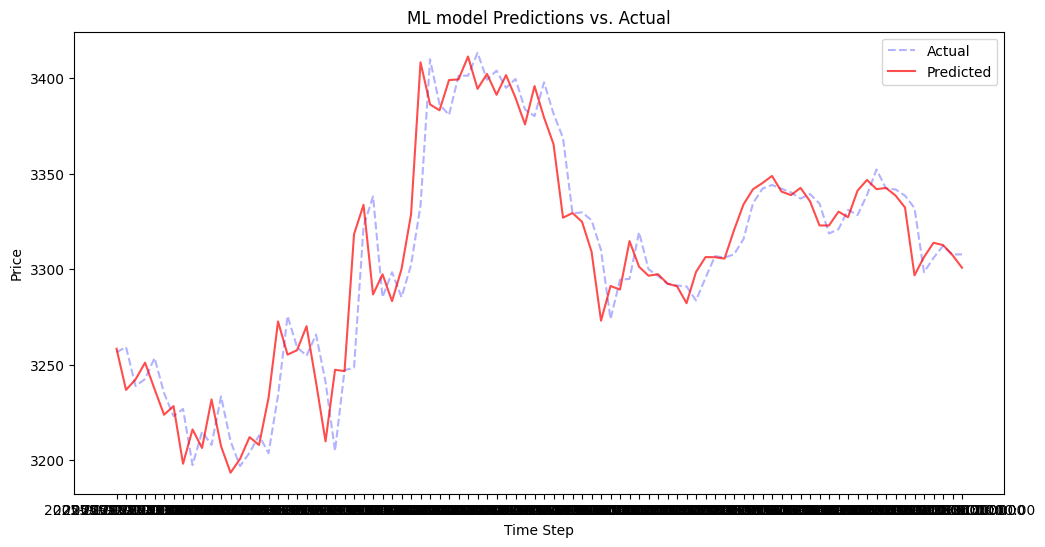

In [274]:
#from plots import plot

def plot(all_predictions, all_targets, title):
    plt.figure(figsize=(12, 6))
    plt.plot(all_targets[-90:], label='Actual', color='blue', linestyle='--', alpha=0.3)
    #plt.plot(all_targets, label='Actual', color='blue', linestyle='--', alpha=0.3)
    plt.plot(all_predictions[-90:], label='Predicted', color='red', alpha=0.7)
    #plt.plot(all_predictions, label='Predicted', color='red', alpha=0.7)
    plt.title(title)
    plt.xlabel("Time Step")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

all_predictions = bt_best_params_test_data['MLPredictions']#['predicted_close']
all_targets = bt_best_params_test_data['Close']#['close']
plot(all_predictions, all_targets, "ML model Predictions vs. Actual")

In [281]:
class TechAnalysisWithMLFilterStrategy(Strategy):
    def init(self):
        self.signal = self.I(lambda: self.data.Signal)
        self.ml_prediction = self.I(lambda: self.data.MLPredictions)
        self.previous_signal = 0

    def next(self):
        current_signal = self.signal[-1]
        predicted_close_price = self.ml_prediction[-1]

        if current_signal == 1 and self.data.Close[-1] < predicted_close_price:
            self.position.close()
            self.buy()

        elif current_signal == -1 and self.data.Close[-1] > predicted_close_price:
            self.position.close()
            self.sell()

        self.previous_signal = current_signal

In [290]:
_ = run_backtest(bt_best_params_test_data, TechAnalysisWithMLFilterStrategy)

Start                     2024-12-26 14:00:00
End                       2025-01-26 13:00:00
Duration                     30 days 23:00:00
Exposure Time [%]                   58.467742
Equity Final [$]                  981821.1896
Equity Peak [$]                  1043107.9896
Return [%]                          -1.817881
Buy & Hold Return [%]               -0.962874
Return (Ann.) [%]                  -18.881563
Volatility (Ann.) [%]               40.387271
Sharpe Ratio                        -0.467513
Sortino Ratio                       -0.604304
Calmar Ratio                        -1.762655
Max. Drawdown [%]                  -10.712002
Avg. Drawdown [%]                   -5.420172
Max. Drawdown Duration        8 days 17:00:00
Avg. Drawdown Duration        3 days 15:00:00
# Trades                                    1
Win Rate [%]                              0.0
Best Trade [%]                      -1.822847
Worst Trade [%]                     -1.822847
Avg. Trade [%]                    